In [35]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,10)

In [36]:
class CancelOut(keras.layers.Layer):
    '''
    CancelOut layer, keras implementation. 
    '''
    def __init__(self, activation='sigmoid', cancelout_loss=True, lambda_1=0.002, lambda_2=0.001):
        super(CancelOut, self).__init__()
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.cancelout_loss = cancelout_loss
        
        if activation == 'sigmoid': self.activation = tf.sigmoid
        if activation == 'softmax': self.activation = tf.nn.softmax

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1],),
            initializer=tf.keras.initializers.Constant(1),
            trainable=True,
        )
    def call(self, inputs):
        if self.cancelout_loss:
            self.add_loss( self.lambda_1 * tf.norm(self.w, ord=1) + self.lambda_2 * tf.norm(self.w, ord=2))
        return tf.math.multiply(inputs, self.activation(self.w))
    
    
    def get_config(self):
        return {"activation": self.activation}    

In [37]:
def plot_importance(importances):
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [38]:
scaler = StandardScaler()
X = scaler.fit_transform(load_breast_cancer()['data'])
y = load_breast_cancer()['target']
features = load_breast_cancer()['feature_names']

### Sigmoid + Loss 

In [39]:
inputs = keras.Input(shape=(X.shape[1],))
x = CancelOut(activation='sigmoid')(inputs)
x = layers.Dense(32, activation="relu")(x)
#x = CancelOut()(x)
x = layers.Dense(32, activation="relu")(x)
#x = CancelOut()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy', 
              optimizer='adam')
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
cancel_out_5 (CancelOut)     (None, 30)                30        
_________________________________________________________________
dense_15 (Dense)             (None, 32)                992       
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 2,111
Trainable params: 2,111
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.fit(X, y, epochs=20, batch_size=8)

Epoch 1/20
72/72 [==============================] - 0s 799us/step - loss: 0.4768
Epoch 2/20
72/72 [==============================] - 0s 813us/step - loss: 0.2149
Epoch 3/20
72/72 [==============================] - 0s 730us/step - loss: 0.1641
Epoch 4/20
72/72 [==============================] - 0s 742us/step - loss: 0.1429
Epoch 5/20
72/72 [==============================] - 0s 740us/step - loss: 0.1288
Epoch 6/20
72/72 [==============================] - 0s 779us/step - loss: 0.1174
Epoch 7/20
72/72 [==============================] - 0s 895us/step - loss: 0.1093
Epoch 8/20
72/72 [==============================] - 0s 747us/step - loss: 0.1023
Epoch 9/20
72/72 [==============================] - 0s 733us/step - loss: 0.0955
Epoch 10/20
72/72 [==============================] - 0s 840us/step - loss: 0.0902
Epoch 11/20
72/72 [==============================] - 0s 798us/step - loss: 0.0849
Epoch 12/20
72/72 [==============================] - 0s 740us/step - loss: 0.0788
Epoch 13/20
72/72 [======

In [41]:
cancelout_feature_importance_sigmoid = model.get_weights()[0]
cancelout_feature_importance_sigmoid

array([0.23360944, 0.7166199 , 0.18183169, 0.0796449 , 0.36645526,
       0.2475115 , 0.5372474 , 0.23054692, 0.2752572 , 0.3597356 ,
       0.5012457 , 0.39871517, 0.2695111 , 0.21219146, 0.331213  ,
       0.35613608, 0.24519855, 0.14574134, 0.3178066 , 0.57525223,
       0.40728638, 0.5422141 , 0.42606953, 0.59417886, 0.65645874,
       0.41864341, 0.500722  , 0.30290195, 0.4685865 , 0.34947008],
      dtype=float32)

### Softmax + No Loss

In [42]:
inputs = keras.Input(shape=(X.shape[1],))
x = CancelOut(activation='softmax', cancelout_loss=False)(inputs)
x = layers.Dense(32, activation="relu")(x)
#x = CancelOut()(x)
x = layers.Dense(32, activation="relu")(x)
#x = CancelOut()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy', 
              optimizer='adam')
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
cancel_out_6 (CancelOut)     (None, 30)                30        
_________________________________________________________________
dense_18 (Dense)             (None, 32)                992       
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 2,111
Trainable params: 2,111
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.fit(X, y, epochs=20, batch_size=8)

Epoch 1/20
72/72 [==============================] - 0s 916us/step - loss: 0.6312
Epoch 2/20
72/72 [==============================] - 0s 740us/step - loss: 0.3737
Epoch 3/20
72/72 [==============================] - 0s 819us/step - loss: 0.1710
Epoch 4/20
72/72 [==============================] - 0s 724us/step - loss: 0.1125
Epoch 5/20
72/72 [==============================] - 0s 785us/step - loss: 0.0935
Epoch 6/20
72/72 [==============================] - 0s 723us/step - loss: 0.0888
Epoch 7/20
72/72 [==============================] - 0s 711us/step - loss: 0.0783
Epoch 8/20
72/72 [==============================] - 0s 806us/step - loss: 0.0734
Epoch 9/20
72/72 [==============================] - 0s 752us/step - loss: 0.0695
Epoch 10/20
72/72 [==============================] - 0s 745us/step - loss: 0.0670
Epoch 11/20
72/72 [==============================] - 0s 723us/step - loss: 0.0655
Epoch 12/20
72/72 [==============================] - 0s 737us/step - loss: 0.0635
Epoch 13/20
72/72 [======

In [44]:
cancelout_feature_importance_softmax = model.get_weights()[0]
cancelout_feature_importance_softmax

array([0.8646685 , 0.9297946 , 1.041775  , 1.0581877 , 0.87913954,
       0.7880292 , 1.070631  , 0.9703354 , 0.71175075, 0.79631186,
       0.8345016 , 0.67362726, 1.0588152 , 1.2686845 , 0.5851457 ,
       0.8804763 , 0.66059697, 0.5979381 , 0.7027532 , 0.890007  ,
       1.3074998 , 1.2685775 , 1.2207824 , 1.1551926 , 1.0438159 ,
       0.5558124 , 1.0898336 , 1.0736428 , 1.0018368 , 0.7529111 ],
      dtype=float32)

### RandomForest Feature Importance 

In [45]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42).fit(X,y)
rf_importances = rnd_clf.feature_importances_

### Plots

Sigmoid + Loss


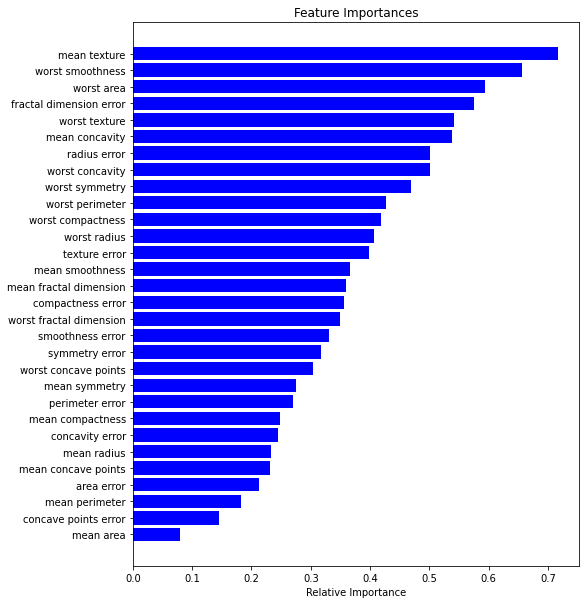

Softmax + No Loss


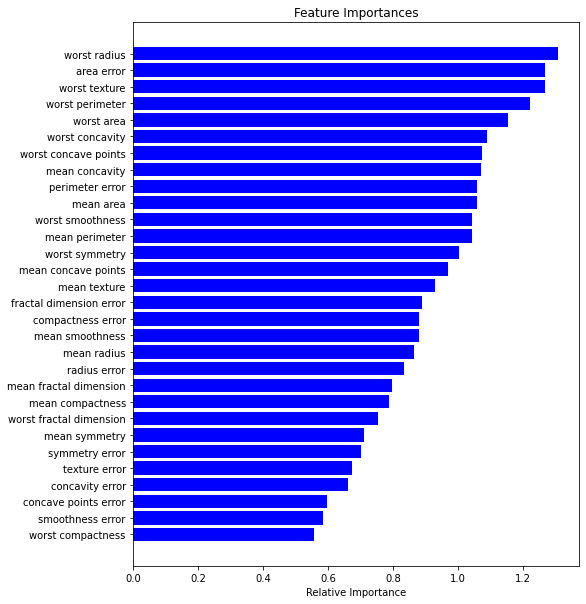

Random Forest


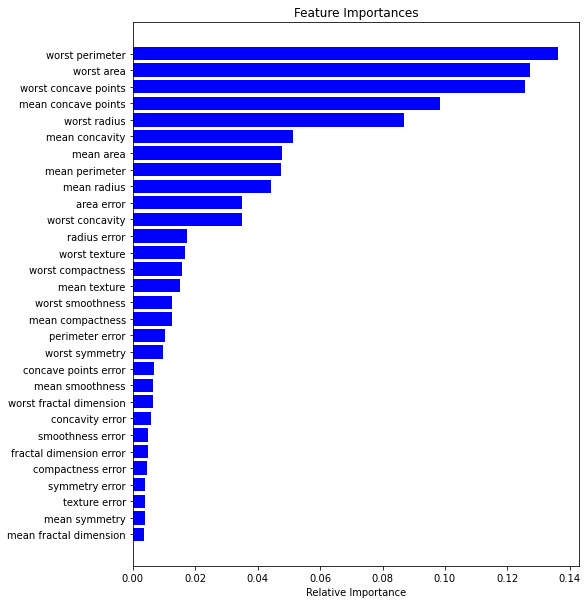

In [47]:
print('Sigmoid + Loss')
plot_importance(cancelout_feature_importance_sigmoid)
print('Softmax + No Loss')
plot_importance(cancelout_feature_importance_softmax)
print("Random Forest")
plot_importance(rf_importances)
